In [ ]:
import os
import torch
import os
import torchvision.models as models
import torch.nn as nn
from deepproblog.dataset import Dataset, DataLoader, QueryDataset
from torch.utils.data import Dataset as TorchDataset
from problog.logic import Term, Constant, Var, list2term
from deepproblog.dataset import ImageDataset
from deepproblog.evaluate import get_confusion_matrix
from torch.amp.autocast_mode import autocast
from torchvision import models, transforms, datasets
from tqdm import tqdm

import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from deepproblog.utils.stop_condition import EpochStop
from deepproblog.optimizer import SGD

from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.query import Query
from deepproblog.train import train_model
import torch.nn as nn
import torch.nn.functional as F

from torch.amp.grad_scaler import GradScaler
from torch.amp.autocast_mode import autocast

In [160]:
# GLOBAL VARS
training_size = None
epochs = 2
batch_size = 16
lr_faces = 0.001
lr_scene = 0.001
lr_model = 0.01

clean_df = False
max_faces = 3

In [161]:
# Directories
script_dir = os.getcwd()
print("script_dir:", script_dir)
base_dir = os.path.dirname(os.path.dirname(script_dir))
print("base_dir:", base_dir)
prolog_dir = os.path.join(base_dir, "prolog")
data_dir = os.path.join(base_dir, "data")
print("data_dir:", data_dir)
findingemo_dir = os.path.join(data_dir, "FindingEmo_Images")
print("findingemo_dir:", findingemo_dir)
prolog_dir = os.path.join(base_dir, "code", "prolog")
print("prolog_dir:", prolog_dir)
model_dir = os.path.join(base_dir, "code", "models")
print("model_dir:", model_dir)

script_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\notebooks
base_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition
data_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data
findingemo_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images
prolog_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\prolog
model_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\models


In [162]:
# try to read all the images to see if any are missing or corrupted
if clean_df:
    df = pd.read_csv(os.path.join(findingemo_dir, "annotations_single.ann"))

    # Delete the columns: "user" and "index" and "datetime"
    if "user" in df.columns and "index" in df.columns and "datetime" in df.columns:
        df = df.drop(columns=["user", "index", "datetime"])

    # remove leading slash from image_path
    if df["image_path"].iloc[0].startswith("/"):
        df["image_path"] = df["image_path"].str.lstrip("/")

    # in the dataframe image_path column, change all the occurences of 'lmertens' to 'anon'
    df["image_path"] = df["image_path"].str.replace("lmertens", "anon", regex=False)
    # change the occurences of *, : ? in the image_path to _
    df["image_path"] = df["image_path"].str.replace("*", "_", regex=False)
    df["image_path"] = df["image_path"].str.replace(":", "_", regex=False)
    df["image_path"] = df["image_path"].str.replace("?", "_", regex=False)
    
    corrupted_indices = []
    for idx, row in df.iterrows():
        if idx % 100 == 0:
            print(f"Checking image {idx}/{len(df)}")
        img_path = os.path.join(findingemo_dir, row['image_path'])
        try:
            img = cv2.imread(img_path)
            if img is None:
                print(f"Image at index {idx} could not be read: {img_path}")
                corrupted_indices.append(idx)
        except Exception as e:
            print(f"Error reading image at index {idx}: {img_path}. Error: {e}")
    print(f"Total corrupted/missing images: {len(corrupted_indices)}")
    print("Corrupted indices:", corrupted_indices)
    # Remove corrupted entries from dataframe
    df = df.drop(index=corrupted_indices).reset_index(drop=True)
    # save the cleaned dataframe as pickle
    df.to_pickle("clean_findingemo.pkl")

else:
    df = pd.read_pickle(os.path.join(script_dir, "clean_findingemo.pkl"))

In [163]:
# corrupted_indices = []
# for idx, row in df.iterrows():
#     if idx % 100 == 0:
#         print(f"Checking image {idx}/{len(df)}")
#     img_path = os.path.join(findingemo_dir, row['image_path'])
#     try:
#         img = cv2.imread(img_path)
#         if img is None:
#             print(f"Image at index {idx} could not be read: {img_path}")
#             corrupted_indices.append(idx)
#     except Exception as e:
#         print(f"Error reading image at index {idx}: {img_path}. Error: {e}")
# print(f"Total corrupted/missing images: {len(corrupted_indices)}")
# print("Corrupted indices:", corrupted_indices)

In [164]:
# set device, move models and maps, set eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [165]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,Trust,"BodyLanguage,FacialExpression",0
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,Interest,FacialExpression,0
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,Interest,BodyLanguage,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,Interest,"BodyLanguage,FacialExpression",4
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,Apprehension,ConflictCtxtPerson,0


In [166]:
def valence_to_class(v):
    if v < 0:
        return "sad"
    if v == 0:
        return "neutral"
    else:
        return "happy"

In [167]:
# I'm going to simplify the emotions to happy, sad and neutral first
df['emo3'] = df['valence'].apply(valence_to_class)

In [168]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity,emo3
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,Trust,"BodyLanguage,FacialExpression",0,neutral
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,Interest,FacialExpression,0,neutral
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,Interest,BodyLanguage,3,happy
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,Interest,"BodyLanguage,FacialExpression",4,happy
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,Apprehension,ConflictCtxtPerson,0,neutral


In [169]:
# Load category names
scene_categories_path = os.path.join(data_dir, "places365/categories_places365.txt")
with open(scene_categories_path) as f:
    scene_categories = [line.strip().split(' ')[0][3:] for line in f]
    # If there is a / in the category name, replace it with _
    scene_categories = [cat.replace('/', '_') for cat in scene_categories]
print("Length of scene categories:", len(scene_categories))  # Should be 365

Length of scene categories: 365


In [170]:
# read the csv file from the data folder
categories_365_path = os.path.join(data_dir, "CategoriesPlaces365.xlsx")

# read as csv
categories_365_df = pd.read_excel(categories_365_path)
categories_365_df.head()

,commercial,summer,sport,playful,royal,relaxing,house_interior,food,cold,scary,transport,work,nature,horeca,agriculture,depressing,industrial,urban,cultural,woods
0,bakery_shop,harbor,arena_hockey,nursery,banquet_hall,jacuzzi_indoor,living_room,pantry,crevasse,attic,airfield,home_office,viaduct,bar,vegetable_garden,hospital,assembly_line,building_facade,church_outdoor,hunting_lodge_outdoor
1,butchers_shop,berth,arena_performance,playroom,ballroom,bedroom,kitchen,dining_room,mountain_snowy,basement,airplane_cabin,bank_vault,dam,pub_indoor,wheat_field,hospital_room,auto_factory,downtown,mosque_outdoor,cottage
2,clothing_store,coast,arena_rodeo,childs_room,bedchamber,bathroom,closet,fastfood_restaurant,ice_floe,alley,airport_terminal,server_room,badlands,cafeteria,wind_farm,jail_cell,engine_room,street,synagogue_outdoor,tree_house
3,department_store,grotto,baseball_field,candy_store,auto_showroom,television_room,dorm_room,restaurant,ice_shelf,catacomb,railroad_track,auditorium,canyon,coffee_shop,barn,army_base,industrial_area,shopfront,temple_asia,inn_outdoor
4,jewelry_shop,islet,basketball_court_indoor,florist_shop_indoor,church_indoor,shower,hotel_room,restaurant_kitchen,iceberg,NaN,train_interior,classroom,cliff,pub_indoor,farm,trench,oilrig,parking_lot,mausoleum,NaN


In [171]:
# get the counts of the labels of emo3
df['emo3'].value_counts()

emo3
happy      13995
sad         8469
neutral     3403
Name: count, dtype: int64

In [172]:
# From the dataframe, create a dictionary that maps every category to its broader category (column where it belongs)
category_mapping = {}
for col in categories_365_df.columns:
    for category in categories_365_df[col].dropna().tolist():
        category_mapping[category] = col

mapped_categories = sorted(list(dict.fromkeys(category_mapping.values())))
print("Mapped Categories:", mapped_categories)

Mapped Categories: ['agriculture', 'cold', 'commercial', 'cultural', 'depressing', 'food', 'horeca', 'house_interior', 'industrial', 'nature', 'playful', 'relaxing', 'royal', 'scary', 'sport', 'summer', 'transport', 'urban', 'woods', 'work']


In [173]:
# Check if all the 365 categories are in the mapping
for cat in scene_categories:
    if cat not in category_mapping:
        print("Category not found in mapping:", cat)

# check if all keys in category_mapping are in scene_categories
for cat in category_mapping.keys():
    if cat not in scene_categories:
        print("Category in mapping not found in scene categories:", cat)

print(len(category_mapping))

365


In [174]:
finding_emo_labels = sorted(df["emotion"].unique().tolist())
print(finding_emo_labels)

['Acceptance', 'Admiration', 'Amazement', 'Anger', 'Annoyance', 'Anticipation', 'Apprehension', 'Boredom', 'Disgust', 'Distraction', 'Ecstasy', 'Fear', 'Grief', 'Interest', 'Joy', 'Loathing', 'Pensiveness', 'Rage', 'Sadness', 'Serenity', 'Surprise', 'Terror', 'Trust', 'Vigilance']


In [175]:
# Build mapping matrix with deterministic column order and float dtype
map_365 = torch.zeros((365, len(mapped_categories)), dtype=torch.float32)
for i, cat in enumerate(scene_categories):
    coarse = category_mapping[cat]
    coarse_idx = mapped_categories.index(coarse)
    map_365[i, coarse_idx] = 1.0

In [176]:
def get_mapped_category(scene_idx_365):
    # print the name of the 365 category
    mapped = map_365[scene_idx_365]
    mapped_idx = torch.argmax(mapped).item()
    print(scene_categories[scene_idx_365], "->", mapped_categories[mapped_idx])

In [177]:
for i in range(len(scene_categories)):
    get_mapped_category(i)

airfield -> transport
airplane_cabin -> transport
airport_terminal -> transport
alcove -> house_interior
alley -> scary
amphitheater -> cultural
amusement_arcade -> playful
amusement_park -> playful
apartment_building_outdoor -> urban
aquarium -> cultural
aqueduct -> nature
arcade -> playful
arch -> cultural
archaelogical_excavation -> cultural
archive -> cultural
arena_hockey -> sport
arena_performance -> sport
arena_rodeo -> sport
army_base -> depressing
art_gallery -> cultural
art_school -> work
art_studio -> cultural
artists_loft -> house_interior
assembly_line -> industrial
athletic_field_outdoor -> sport
atrium_public -> work
attic -> scary
auditorium -> work
auto_factory -> industrial
auto_showroom -> royal
badlands -> nature
bakery_shop -> commercial
balcony_exterior -> urban
balcony_interior -> house_interior
ball_pit -> playful
ballroom -> royal
bamboo_forest -> nature
bank_vault -> work
banquet_hall -> royal
bar -> horeca
barn -> agriculture
barndoor -> house_interior
baseba

In [178]:
# Now create train/test splits with clean data
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_test = df_train.reset_index(drop=True), df_test.reset_index(drop=True)
print("Training set shape: ",df_train.shape)
print("Test set shape: ",df_test.shape)

Training set shape:  (20693, 9)
Test set shape:  (5174, 9)


In [179]:
def show_image(dataframe, index):
    img_path = os.path.join(findingemo_dir, dataframe.loc[index, 'image_path'])
    print("Image path:", img_path)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Image path: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images\Run_2/Pain teenagers rally/GF36ZVIIE5RV4RXMLC6PVLBU5Q.jpg


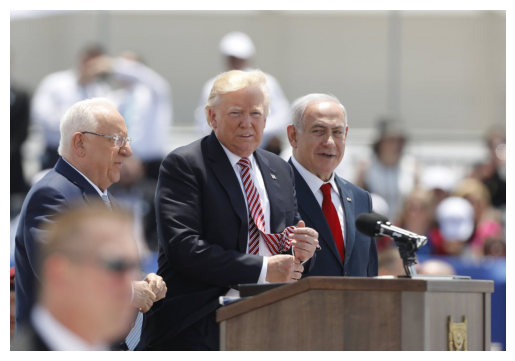

In [180]:
show_image(df_train, 4)


In [181]:
fer_classes = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

In [182]:
print(torch.cuda.is_available())
NUM_CLASSES = 7                  # FER2013 has 7 classes
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [ ]:
def train_resnet_fer2013(resnet_version=18,
                         batch_size=128,
                         lr=2e-4,
                         epochs=15,
                         save_name=None):
    print(f"Training ResNet-{resnet_version} on FER2013")
    print(f"Batch size: {batch_size}, LR: {lr}, Epochs: {epochs}")

    print("Using device:", DEVICE)

    # let cuDNN pick the fastest kernels for this image size
    torch.backends.cudnn.benchmark = True

    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225]),
    ])


    root = os.path.join(data_dir, "fer2013")      
    train_dataset = datasets.ImageFolder(root=f"{root}/train",
                                        transform=transform)
    val_dataset   = datasets.ImageFolder(root=f"{root}/test",
                                        transform=transform)

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=2, pin_memory=True, persistent_workers=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=2, pin_memory=True, persistent_workers=True
    )

    print("Train samples:", len(train_dataset))
    print("Val samples:", len(val_dataset))

    if resnet_version == 18:
        resnet = models.resnet18(weights="IMAGENET1K_V1")
    elif resnet_version == 50:
        resnet = models.resnet50(weights="IMAGENET1K_V2")
        
    num_features = resnet.fc.in_features
    resnet.fc = nn.Linear(num_features, NUM_CLASSES)
    resnet = resnet.to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(resnet.parameters(), lr=lr)

    scaler = GradScaler()

     # Determine save path
    if save_name is None:
        save_name = f"resnet{resnet_version}_fer2013.pth"
    save_path = os.path.join(model_dir, save_name)

    best_val_acc = 0.0

    for epoch in range(epochs):
        resnet.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images = images.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type="cuda"):         
                outputs = resnet(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = 100. * correct / total
        print(f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.2f}%")

        # ---------------- Validation ----------------
        resnet.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(DEVICE, non_blocking=True)
                labels = labels.to(DEVICE, non_blocking=True)
                with autocast(device_type="cuda"):
                    outputs = resnet(images)
                    loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = 100. * val_correct / val_total
        print(f"Val Loss {val_loss:.4f} | Val Acc {val_acc:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(resnet.state_dict(), save_path)
            print(f"Best model saved to {save_path} | Val Acc: {val_acc:.2f}%")

    print(f"\nTraining complete! Best validation accuracy: {best_val_acc:.2f}%")
    return best_val_acc


In [ ]:
def predict_and_show_fer2013(model_path, image_path=None, resnet_version=18):
    """
    Load a trained model and predict emotion on a FER2013 image.
    
    Args:
        model_path: path to saved model weights (.pth file)
        image_path: path to image (if None, picks random from test set)
        resnet_version: 18 or 50 (must match the saved model)
    """
    fer_classes = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    NUM_CLASSES = 7
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model
    if resnet_version == 18:
        resnet = models.resnet18(weights="IMAGENET1K_V1")
    elif resnet_version == 50:
        resnet = models.resnet50(weights="IMAGENET1K_V2")
    else:
        raise ValueError("resnet_version must be 18 or 50")
    
    num_features = resnet.fc.in_features
    resnet.fc = nn.Linear(num_features, NUM_CLASSES)
    resnet.load_state_dict(torch.load(model_path, map_location=DEVICE))
    resnet = resnet.to(DEVICE)
    resnet.eval()
    
    # Get image path
    if image_path is None:
        # Pick random image from test set
        test_folder = os.path.join(data_dir, "fer2013", "test")
        all_test_images = []
        for emotion_class in os.listdir(test_folder):
            class_path = os.path.join(test_folder, emotion_class)
            if os.path.isdir(class_path):
                all_test_images.extend(glob.glob(os.path.join(class_path, "*.jpg")))
                all_test_images.extend(glob.glob(os.path.join(class_path, "*.png")))
        image_path = random.choice(all_test_images)
    
    # Get true label from folder name
    true_label = os.path.basename(os.path.dirname(image_path))
    
    # Preprocess image
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(DEVICE)
    
    # Predict
    with torch.no_grad():
        with autocast(device_type="cuda"):
            outputs = resnet(image_tensor)
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]
    
    # Get predicted class
    predicted_idx = probabilities.argmax()
    predicted_label = fer_classes[predicted_idx]
    confidence = probabilities[predicted_idx] * 100
    
    # Display results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Show image
    ax1.imshow(Image.open(image_path).convert("RGB"))
    ax1.axis('off')
    ax1.set_title(f"True: {true_label}\nPredicted: {predicted_label} ({confidence:.1f}%)", 
                  fontsize=12, fontweight='bold')
    
    # Show probability distribution
    ax2.barh(fer_classes, probabilities)
    ax2.set_xlabel('Probability')
    ax2.set_title('Emotion Probabilities')
    ax2.set_xlim([0, 1])
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print(f"\n{'='*50}")
    print(f"Image: {os.path.basename(image_path)}")
    print(f"True Label: {true_label}")
    print(f"Predicted: {predicted_label} ({confidence:.1f}%)")
    print(f"{'='*50}")
    print("\nAll probabilities:")
    for emotion, prob in zip(fer_classes, probabilities):
        bar = '█' * int(prob * 50)
        print(f"{emotion:10s} {prob:.4f} {bar}")

In [183]:
# # =====================================================
# # 1. Imports
# # =====================================================
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader
# from torchvision import models, transforms, datasets
# from tqdm import tqdm

# # =====================================================
# # 2. Hyper-parameters
# # =====================================================
# BATCH_SIZE = 256                 # try 128 if VRAM < 4 GB
# LR = 2e-4
# EPOCHS = 15
# NUM_CLASSES = 7                  # FER2013 has 7 classes
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", DEVICE)

# # let cuDNN pick the fastest kernels for this image size
# torch.backends.cudnn.benchmark = True

# # =====================================================
# # 3. Data transforms
# # =====================================================
# transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=3),
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225]),
# ])

# # =====================================================
# # 4. Load FER2013 dataset
# #     (expects train/ and test/ folders inside data_dir)
# # =====================================================
# root = os.path.join(data_dir, "fer2013")          # change to your path
# train_dataset = datasets.ImageFolder(root=f"{root}/train",
#                                      transform=transform)
# val_dataset   = datasets.ImageFolder(root=f"{root}/test",
#                                      transform=transform)

# train_loader = DataLoader(
#     train_dataset, batch_size=BATCH_SIZE, shuffle=True,
#     num_workers=2, pin_memory=True, persistent_workers=True
# )
# val_loader = DataLoader(
#     val_dataset, batch_size=BATCH_SIZE, shuffle=False,
#     num_workers=2, pin_memory=True, persistent_workers=True
# )

# print("Train samples:", len(train_dataset))
# print("Val samples:", len(val_dataset))

# # =====================================================
# # 5. Build ResNet-18 backbone
# # =====================================================
# resnet = models.resnet18(weights="IMAGENET1K_V1")
# num_features = resnet.fc.in_features
# resnet.fc = nn.Linear(num_features, NUM_CLASSES)
# resnet = resnet.to(DEVICE)

# # =====================================================
# # 6. Loss, optimizer and mixed precision tools
# # =====================================================
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(resnet.parameters(), lr=LR)

# # Use torch.cuda.amp (not torch.amp.*)
# from torch.amp.grad_scaler import GradScaler
# from torch.amp.autocast_mode import autocast
# scaler = GradScaler()

# # =====================================================
# # 7. Training loop
# # =====================================================
# for epoch in range(EPOCHS):
#     resnet.train()
#     running_loss, correct, total = 0.0, 0, 0

#     for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
#         images = images.to(DEVICE, non_blocking=True)
#         labels = labels.to(DEVICE, non_blocking=True)

#         optimizer.zero_grad(set_to_none=True)
#         with autocast(device_type="cuda"):         
#             outputs = resnet(images)
#             loss = criterion(outputs, labels)

#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()

#         running_loss += loss.item() * images.size(0)
#         _, predicted = outputs.max(1)
#         total += labels.size(0)
#         correct += predicted.eq(labels).sum().item()

#     train_loss = running_loss / total
#     train_acc = 100. * correct / total
#     print(f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.2f}%")

#     # ---------------- Validation ----------------
#     resnet.eval()
#     val_loss, val_correct, val_total = 0.0, 0, 0
#     with torch.no_grad():
#         for images, labels in val_loader:
#             images = images.to(DEVICE, non_blocking=True)
#             labels = labels.to(DEVICE, non_blocking=True)
#             with autocast(device_type="cuda"):
#                 outputs = resnet(images)
#                 loss = criterion(outputs, labels)
#             val_loss += loss.item() * images.size(0)
#             _, predicted = outputs.max(1)
#             val_correct += predicted.eq(labels).sum().item()
#             val_total += labels.size(0)

#     val_loss /= val_total
#     val_acc = 100. * val_correct / val_total
#     print(f"Val Loss {val_loss:.4f} | Val Acc {val_acc:.2f}%")

# # =====================================================
# # 8. Save model
# # =====================================================
# torch.save(resnet.state_dict(), "resnet18_fer2013.pth")
# print("Model saved to resnet18_fer2013.pth")


In [184]:
# # =====================================================
# # 1. Imports
# # =====================================================
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader
# from torchvision import models, transforms, datasets
# from tqdm import tqdm

# # =====================================================
# # 2. Hyper-parameters
# # =====================================================
# BATCH_SIZE = 64                 # try 128 if VRAM < 4 GB
# LR = 2e-4
# EPOCHS = 15
# NUM_CLASSES = 7                  # FER2013 has 7 classes
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", DEVICE)

# # let cuDNN pick the fastest kernels for this image size
# torch.backends.cudnn.benchmark = True

# # =====================================================
# # 3. Data transforms
# # =====================================================
# transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=3),
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225]),
# ])

# # =====================================================
# # 4. Load FER2013 dataset
# #     (expects train/ and test/ folders inside data_dir)
# # =====================================================
# root = os.path.join(data_dir, "fer2013")          # change to your path
# train_dataset = datasets.ImageFolder(root=f"{root}/train",
#                                      transform=transform)
# val_dataset   = datasets.ImageFolder(root=f"{root}/test",
#                                      transform=transform)

# train_loader = DataLoader(
#     train_dataset, batch_size=BATCH_SIZE, shuffle=True,
#     num_workers=2, pin_memory=True, persistent_workers=True
# )
# val_loader = DataLoader(
#     val_dataset, batch_size=BATCH_SIZE, shuffle=False,
#     num_workers=2, pin_memory=True, persistent_workers=True
# )

# print("Train samples:", len(train_dataset))
# print("Val samples:", len(val_dataset))

# # =====================================================
# # 5. Build ResNet-50 backbone
# # =====================================================
# resnet = models.resnet50(weights="IMAGENET1K_V2")
# num_features = resnet.fc.in_features
# resnet.fc = nn.Linear(num_features, NUM_CLASSES)
# resnet = resnet.to(DEVICE)

# # =====================================================
# # 6. Loss, optimizer and mixed precision tools
# # =====================================================
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(resnet.parameters(), lr=LR)

# # Use torch.cuda.amp (not torch.amp.*)
# from torch.amp.grad_scaler import GradScaler
# from torch.amp.autocast_mode import autocast
# scaler = GradScaler()

# # =====================================================
# # 7. Training loop
# # =====================================================
# for epoch in range(EPOCHS):
#     resnet.train()
#     running_loss, correct, total = 0.0, 0, 0

#     for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
#         images = images.to(DEVICE, non_blocking=True)
#         labels = labels.to(DEVICE, non_blocking=True)

#         optimizer.zero_grad(set_to_none=True)
#         with autocast(device_type="cuda"):         
#             outputs = resnet(images)
#             loss = criterion(outputs, labels)

#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()

#         running_loss += loss.item() * images.size(0)
#         _, predicted = outputs.max(1)
#         total += labels.size(0)
#         correct += predicted.eq(labels).sum().item()

#     train_loss = running_loss / total
#     train_acc = 100. * correct / total
#     print(f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.2f}%")

#     # ---------------- Validation ----------------
#     resnet.eval()
#     val_loss, val_correct, val_total = 0.0, 0, 0
#     with torch.no_grad():
#         for images, labels in val_loader:
#             images = images.to(DEVICE, non_blocking=True)
#             labels = labels.to(DEVICE, non_blocking=True)
#             with autocast(device_type="cuda"):
#                 outputs = resnet(images)
#                 loss = criterion(outputs, labels)
#             val_loss += loss.item() * images.size(0)
#             _, predicted = outputs.max(1)
#             val_correct += predicted.eq(labels).sum().item()
#             val_total += labels.size(0)

#     val_loss /= val_total
#     val_acc = 100. * val_correct / val_total
#     print(f"Val Loss {val_loss:.4f} | Val Acc {val_acc:.2f}%")

# # =====================================================
# # 8. Save model
# # =====================================================
# torch.save(resnet.state_dict(), "resnet50_fer2013.pth")
# print("Model saved to resnet50_fer2013.pth")


In [ ]:
# =====================================================
# 3. Data transforms
# =====================================================
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# =====================================================
# 4. Load FER2013 dataset
#     (expects train/ and test/ folders inside data_dir)
# =====================================================
root = os.path.join(data_dir, "fer2013")          # change to your path
train_dataset = datasets.ImageFolder(root=f"{root}/train",
                                     transform=transform)
val_dataset   = datasets.ImageFolder(root=f"{root}/test",
                                     transform=transform)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=2, pin_memory=True, persistent_workers=True
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True, persistent_workers=True
)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))

In [185]:
# Write a function that outputs the prob sitribution over the 7 classes for a given image path
def predict_emotion(image_path, resnet_version):
    if resnet_version == 18:
        model_path = os.path.join(model_dir, "resnet18_fer2013.pth")
        resnet = models.resnet18(weights="IMAGENET1K_V1")
    elif resnet_version == 50:
        model_path = os.path.join(model_dir, "resnet50_fer2013.pth")
        resnet = models.resnet50(weights="IMAGENET1K_V2")
    else:
        raise ValueError("resnet_version must be 18 or 50")
    # Load the model
    num_features = resnet.fc.in_features
    resnet.fc = nn.Linear(num_features, NUM_CLASSES)
    resnet.load_state_dict(torch.load(model_path))
    resnet = resnet.to(DEVICE)
    resnet.eval()

    # Load and preprocess the image
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(DEVICE)

    # Predict
    with torch.no_grad():
        with autocast(device_type="cuda"):
            outputs = resnet(image)
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]

    # Show the image and below the probabilities for each class
    plt.imshow(Image.open(image_path).convert("RGB"))
    plt.axis('off')
    plt.show()
    for i, (emotion, prob) in enumerate({fer_classes[i]: probabilities[i] for i in range(NUM_CLASSES)}.items()):
        print(f"{emotion}: {prob:.4f}")

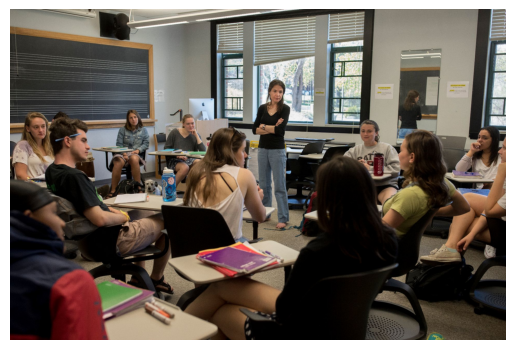

angry: 0.8105
disgust: 0.0000
fear: 0.0287
happy: 0.0000
sad: 0.0005
surprise: 0.1602
neutral: 0.0001


In [ ]:
predict_emotion(os.path.join(data_dir, "fer2013", "some_image.jpg"), resnet_version=18)

In [187]:
# from retinaface import RetinaFace

# # iter over the dataframe and detect faces in each image
# for idx, row in df.iterrows():
#     img_path = os.path.join(findingemo_dir, row['image_path'])
#     faces = RetinaFace.detect_faces(img_path)
    